In [1]:
import torch
from torch import nn
from torchsummary import summary
import matplotlib.pyplot as plt
import models
import utils
import json

In [ ]:
with open('configuration.json') as file:
    configuration = json.load(file)

IMG_HEIGHT = configuration["image"]["heigth"]
IMG_WIDTH = configuration["image"]["width"]
IMG_CHANNELS = configuration["image"]["channels"]
MODEL_PATH = configuration["path"]["models"]

device = utils.select_device()
model = models.UNet(in_channels=IMG_CHANNELS, out_channels=1).to(device)
summary(model, input_size=(IMG_CHANNELS, IMG_HEIGHT, IMG_WIDTH))

GPU disponible
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             448
              ReLU-2         [-1, 16, 256, 256]               0
            Conv2d-3         [-1, 16, 256, 256]           2,320
              ReLU-4         [-1, 16, 256, 256]               0
        DoubleConv-5         [-1, 16, 256, 256]               0
         MaxPool2d-6         [-1, 16, 128, 128]               0
            Conv2d-7         [-1, 32, 128, 128]           4,640
              ReLU-8         [-1, 32, 128, 128]               0
            Conv2d-9         [-1, 32, 128, 128]           9,248
             ReLU-10         [-1, 32, 128, 128]               0
       DoubleConv-11         [-1, 32, 128, 128]               0
        MaxPool2d-12           [-1, 32, 64, 64]               0
           Conv2d-13           [-1, 64, 64, 64]          18,496
             ReLU-14    

In [3]:
X, Y = utils.load_images()
train_loader, validation_loader, test_loader = utils.create_loader(X, Y)

100%|██████████| 2680/2680 [00:54<00:00, 49.02it/s]


In [4]:
model = models.UNet()
model.to(device)

# Definimos los hiperparámetros
n_epochs = 1000
lr=0.0001
patience = 20 # (vamos a usar early stopping, así que definimos un valor de paciencia)

# Definimos la función de pérdida (error cuadrático medio)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [5]:
# Definimos las funciones de entrenamiento y evaluación

def train(model,loader):
    total_loss = 0.0
    for data in loader:
        model.train()
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device).unsqueeze(1)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
    total_loss/= len(loader.dataset)
    return total_loss 


def test(model,loader):
    model.eval()
    total_loss = 0.0
    for data in loader:
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device).unsqueeze(1)
        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, targets)
        total_loss += loss.item() * inputs.size(0)
    total_loss/= len(loader.dataset)
    return total_loss

In [6]:
# Entrenamos con early stopping

# Valores iniciales para el early stopping
best_val_loss = 10000.0
best_train_loss = 10000.0
j = 0
epoch = 0
selected_model_state_dict = model.state_dict()

while ((epoch < n_epochs) and (j < patience)):
    train_loss = train(model, train_loader)
    validation_loss = test(model, validation_loader)
    
    if epoch%10 == 0:
        print('Epoca: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Train loss: {:.4f}".format(train_loss), ", Validation loss: {:.4f}".format(validation_loss))
        
    if (validation_loss <= best_val_loss):
        best_epoch = epoch
        best_train_loss = train_loss
        best_val_loss = validation_loss
        selected_model_state_dict = model.state_dict()
        j = 0
    else:
        j += 1

    epoch += 1
        
print('La mejor Epoca fue {:03d}, Train loss: {:.4f}, Validation loss: {:.4f}'.format(
              best_epoch, best_train_loss, best_val_loss))

# Nos quedamos con el modelo con mejor valor de validación  
model.load_state_dict(selected_model_state_dict)

Epoca: 0/1000............. Train loss: 0.6544 , Validation loss: 0.6298
Epoca: 10/1000............. Train loss: 0.1322 , Validation loss: 0.1291
Epoca: 20/1000............. Train loss: 0.1099 , Validation loss: 0.1073
Epoca: 30/1000............. Train loss: 0.1001 , Validation loss: 0.0991
Epoca: 40/1000............. Train loss: 0.0926 , Validation loss: 0.0919
Epoca: 50/1000............. Train loss: 0.1149 , Validation loss: 0.1026
Epoca: 60/1000............. Train loss: 0.0839 , Validation loss: 0.0845
Epoca: 70/1000............. Train loss: 0.0786 , Validation loss: 0.0805
Epoca: 80/1000............. Train loss: 0.0760 , Validation loss: 0.0749
Epoca: 90/1000............. Train loss: 0.0728 , Validation loss: 0.0762
Epoca: 100/1000............. Train loss: 0.0705 , Validation loss: 0.0721
Epoca: 110/1000............. Train loss: 0.0692 , Validation loss: 0.0696
Epoca: 120/1000............. Train loss: 0.0675 , Validation loss: 0.0716
Epoca: 130/1000............. Train loss: 0.0669 ,

<All keys matched successfully>

In [7]:
torch.save(model.state_dict(), "./models/unet.pth")

In [8]:
model.load_state_dict(torch.load("./models/unet.pth"))

C:\Users\mauri\AppData\Local\Temp\ipykernel_13804\2079416734.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./models/unet.pth"))


<All keys matched successfully>

In [9]:
model.eval()
idx = 12
input = torch.tensor(X[idx], dtype=torch.float32).unsqueeze(0).to(device)
mask = Y[idx]
with torch.no_grad():
    output = model(input)

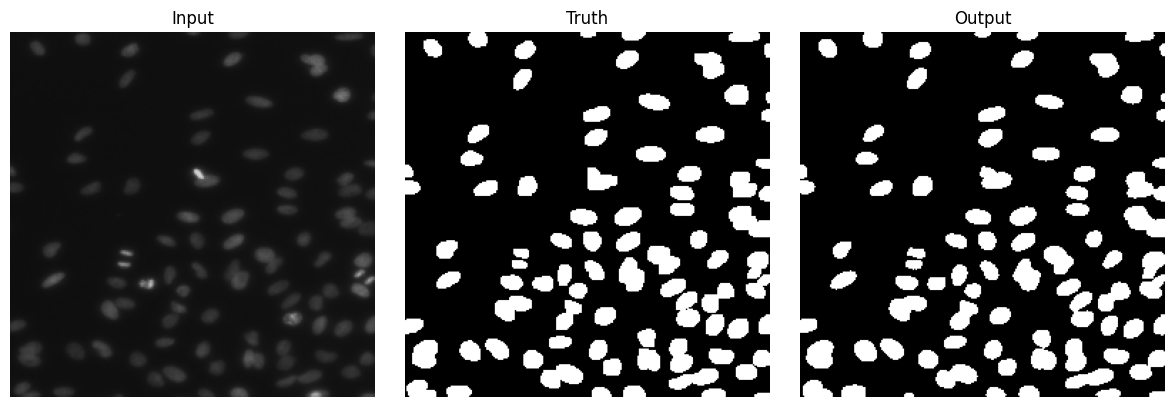

In [10]:
input_image = input.squeeze().permute(1, 2, 0).cpu().numpy()/255
mask_image = mask
output = (output > 0.5)
output_image = output.squeeze().cpu().numpy()/255

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(input_image)
axs[0].set_title("Input")

axs[1].imshow(mask_image, cmap = "grey")  # Si tienes ground truth
axs[1].set_title("Truth")

axs[2].imshow(output_image, cmap = "grey")  # Si tienes ground truth
axs[2].set_title("Output")

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
a, b = utils.test_similarity(model, zip(X, Y))

Dice: 0.9064167382233662
Jaccard: 0.8371506714551352
0.9064167382233662
0.8371506714551352
